In [1]:
import pandas as pd
import tensorflow as tf
import classification_utils
import numpy as np
import os
import pickle


2022-12-11 13:24:16.957466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 13:24:17.301938: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-11 13:24:17.301981: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-11 13:24:19.464566: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
df = pd.read_csv("./dataset/users_df_dataset_cleaned_with_indicators.csv")

We are going to use only the numerical attributes, except for the bot column that is the target one

In [3]:
df = df[[
#    "user_id"  ,
#    "name"  ,
#    "lang"  ,
    "bot"  ,
#    "created_at" ,
    "statuses_count" ,
    "account_age_in_days" ,
    "number_of_tweets" ,
    "account_average_tweets_per_day" ,
    "avg_tweets_per_actual_day" ,
#    "day_with_most_tweets" ,
    "max_number_of_tweets_in_a_day",
    "entropy_for_day",
    "entropy_for_hour",
    "entropy_for_minute",
    "avg_hashtags",
    "avg_text_length",
    "avg_mentions",
    "avg_special_char_in_text",
    "total_likes",
    "avg_favorite_count",
    "total_replies",
    "avg_reply_count",
    "total_retweet_count",
    "account_discussion_creation_ratio",
    "tweet_num_likes_ratio",
    "tweet_num_replies_ratio",
    "entropy_original_text",
    "entropy_text",
    "mean_inactive_period_length_in_seconds",
    "median_inactive_period_length_in_seconds",
    "mode_inactive_period_length_in_seconds",
    "mode_count"
]]

In the next 3 lines we shuffle the data in order to avoid biases if for example all the bot are in the bottom part and they will be part only of the test set, then we split the bot column from the other ones and convert them to a tensor 

In [4]:
from sklearn.preprocessing import minmax_scale

df = df.sample(frac=1, random_state=1)
target_array = df.pop("bot").values
feature_matrix = df.values
feature_matrix = minmax_scale(feature_matrix) #TODO scale traning set separately

In [5]:
df.head()

,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,max_number_of_tweets_in_a_day,entropy_for_day,entropy_for_hour,entropy_for_minute,avg_hashtags,...,total_retweet_count,account_discussion_creation_ratio,tweet_num_likes_ratio,tweet_num_replies_ratio,entropy_original_text,entropy_text,mean_inactive_period_length_in_seconds,median_inactive_period_length_in_seconds,mode_inactive_period_length_in_seconds,mode_count
2987,68,2163,2074,0.031438,10.690722,43,4.577648,2.202349,0.822681,0.248795,...,1334112,0.001555,3.405583,0.0,10.853126,2.747561e-07,53500.641273,845.5,0.0,153
7999,68,1005,3457,0.067662,86.425000,224,5.103056,4.158180,1.425546,0.014753,...,377448,0.009159,1.328593,0.0,11.556204,2.491898e-07,3151.758461,56.0,0.0,282
8447,1785,2521,1238,0.708052,3.134177,21,2.742274,1.435677,0.466968,0.371567,...,133842,0.009250,77.375000,0.0,10.126784,2.269985e-07,114544.543619,5181.0,0.0,91
7109,68,3078,2254,0.022092,7.772414,59,4.183229,2.123818,0.763846,0.526619,...,167190,0.013482,2.782716,0.0,10.998077,2.118565e-07,84270.544809,919.5,0.0,171
2519,68,2017,3010,0.033713,25.083333,86,5.359900,3.144455,0.907828,0.018272,...,553115,0.005442,1.718037,0.0,11.390271,3.563860e-07,32652.958472,197.0,0.0,227


We split the data in training, validation and test.
The training data are the only ones used to fit the neural network, the expactation is that the classification error on this set will only decrease durning the training.

The validation data are used to itaratively evaluate the network and select the best architecture, if the classification error on the validation set increases, it means that the network is in overfit.

The test set is used only after the choise of the final model and is used to have an idea of the error of the network on completely new data

In [6]:
tr_size = 0.7
vl_size = 0.2
ts_size = 0.1

tr_index = round(len(feature_matrix) * tr_size)
vl_index = tr_index + round(len(feature_matrix) * vl_size)
ts_index = vl_index + round(len(feature_matrix) * ts_size)

feature_matrix_tr = feature_matrix[0:tr_index]
target_array_tr = target_array[0:tr_index]

feature_matrix_vl = feature_matrix[tr_index:vl_index]
target_array_vl = target_array[tr_index:vl_index]

feature_matrix_ts = feature_matrix[vl_index:ts_index]
target_array_ts = target_array[vl_index:ts_index]

In [7]:
feature_matrix_tr.shape

(7776, 27)

The choose of the neural network architecture is guided by the theory: since we already have processed features (and not row data), and there is no sign of a hierarchy of features to exploit with the inductive bias of a deep neural network (as for the image classification), we expect to adopt a shallow model, with only few hiddel layers.


https://www.deeplearningbook.org/

https://www.nature.com/articles/nature14539

We set up a very huge grid search in order to find the best hyperparameters for our model, then we explore this grid with a random search of 200 attemps, each one repeted two times in order to decrease the variance.

We want to remember that the attributes are already scaled in order to don't focus the network's efforts on just one attribute.

In [41]:
import keras_tuner

class my_HyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = tf.keras.Sequential()
        for i in range(1, hp.Choice("num_layers", [1, 2, 3, 4, 5]) + 1):
            model.add(tf.keras.layers.Dense(
                hp.Choice(f"units_layer_{i}", [32, 64, 128, 256]),
                activation='relu'))
       
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        
        model.compile(
            optimizer=tf.keras.optimizers.SGD(
                learning_rate = hp.Choice('learning_rate', [0.05, 0.1, 0.2]),
                momentum=0.0,
                nesterov=False,
                weight_decay=hp.Choice('weight_decay', [1e-5, 1e-4, 1e-3]),
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                jit_compile=True,
                name="SGD"
            ), 
            loss="binary_crossentropy", 
            metrics=["accuracy"]
            )
        return model


    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            **kwargs,
            shuffle=True,
            epochs=hp.Choice("epochs",  [250, 500]),
            batch_size=hp.Choice("batch_size",  [1024, 2048]),
            verbose=0,
            workers=8,
            use_multiprocessing=True
            )
        

tuner = keras_tuner.RandomSearch(
    hypermodel=my_HyperModel(),
    objective="val_accuracy",
    max_trials=200,
    executions_per_trial=2,
    overwrite=False,
    directory="./models/keras_tuner",
    project_name="nn_classification",
)


tuner.search(feature_matrix_tr , target_array_tr, validation_data=(feature_matrix_vl, target_array_vl))
model = tuner.get_best_models()[0]




Trial 200 Complete [00h 00m 52s]
val_accuracy: 0.8400090038776398

Best val_accuracy So Far: 0.8442844152450562
Total elapsed time: 02h 23m 40s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [42]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 4,
 'units_layer_1': 128,
 'learning_rate': 0.2,
 'weight_decay': 0.0001,
 'units_layer_2': 128,
 'units_layer_3': 256,
 'units_layer_4': 256,
 'units_layer_5': 256,
 'epochs': 500,
 'batch_size': 1024}

In [43]:
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(target_array_tr, model.predict(feature_matrix_tr) >= 0.5 ))
print('Accuracy validation set ', metrics.accuracy_score(target_array_vl, model.predict(feature_matrix_vl) >= 0.5 ))

243/243 [==============================] - 1s 2ms/step
Accuracy train set  0.8478652263374485
70/70 [==============================] - 0s 2ms/step
Accuracy validation set  0.8442844284428442


As you can see, we are able to achive a really good accuracy (near 85%), without overfitting 

As a counter example,in the following picture we want to demostrate that a larger nework is able to achive 100% accuracy, but then the generalization capabilities are really low because of overfitting, infact the classification error on the validation begin to increase.

We moved the code on anothe file for clarity. The network has 5 hiddel layers with 512 neurons for each layer

/home/matteo/.local/lib/python3.10/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


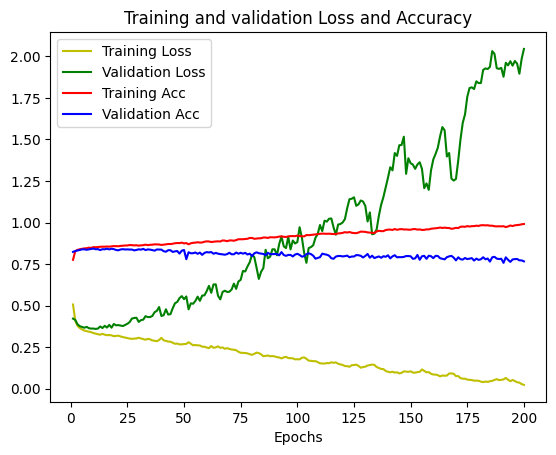

In [16]:
classification_utils.large_model_example(
    feature_matrix_tr,
    target_array_tr,
    feature_matrix_vl,
    target_array_vl
    )

Finally we evaluate the model on completely unseen data, this is like to predict if a new user is a bot or not, i.e. the final objective of the task

35/35 [==============================] - 0s 2ms/step


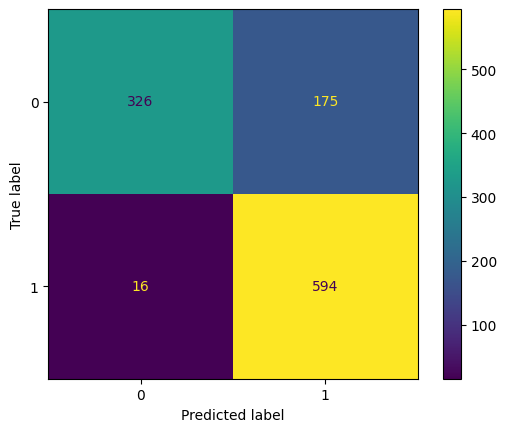

In [44]:
test_predict = (model.predict(feature_matrix_ts) > 0.5).astype("bool")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(target_array_ts, test_predict)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

The model seems very good at indentify true bots, while has a little bias to classify real users as boot too (false positive). 

The dataset is only slightly unbalanced (5000 humans, 6000 bots), so we think that this little bias is an intrinsic difficulty of the task and it is impossible to correct the model without taking it to store the data, and thus not being able to generalize. 

This hypothesis is also supported by the fact that other classification models achieve the same result at most.

In [45]:
from sklearn import metrics
print('Accuracy test set ', metrics.accuracy_score(target_array_ts, test_predict))
print('Precision test set ', metrics.precision_score(target_array_ts, test_predict))
print('Recall test set ', metrics.recall_score(target_array_ts, test_predict))
print('F1 score test set ', metrics.f1_score(target_array_ts, test_predict))

Accuracy test set  0.828082808280828
Precision test set  0.7724317295188556
Recall test set  0.9737704918032787
F1 score test set  0.8614938361131255


## Exporting model

In [46]:
saved_filepath = "models/nn_model"
model.save(saved_filepath)

INFO:tensorflow:Assets written to: models/nn_model/assets


INFO:tensorflow:Assets written to: models/nn_model/assets
